# LOAD & CLEAN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.impute import KNNImputer
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif
pd.set_option('display.max_rows', 300)

In [2]:
SVRM3_ewon_df = pd.read_feather('SVRM3_ewon_complete.feather')
SVRM4_ewon_df = pd.read_feather('SVRM4_ewon_complete.feather')
temp_df = pd.read_feather('Temps_complete.feather')

In [ ]:
def clean_data(df):
    df = df.drop_duplicates()
    
    df = df.copy()
    df['TimeStr'] = pd.to_datetime(df['TimeStr'], format="%d/%m/%Y %H:%M:%S")
    
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
    
    df = df.replace(["Undef", "nan"], np.nan)
    
    mask = (df.iloc[:, 2:].isna()).all(axis=1)
    print(len(mask), "rows only have NaN entries (except Timestamps)")
    df_not_nan = df[~mask]
    
    df_not_nan = df_not_nan.dropna(axis=1, how='all')
    
    subset=["TimeStr"]
    
    print(len(df_not_nan[df_not_nan.duplicated(subset=subset)]), "rows are duplicated on TimeStr")
    df_cleaned = df_not_nan.loc[
    df_not_nan.assign(n_missing=df_not_nan.isna().sum(axis=1))
      .sort_values("n_missing")
      .drop_duplicates(subset=subset, keep="first")
      .index
]
    
    # temporary: remove wisselblok settings columns, none of them is relevant currently
    cols_to_drop = [col for col in df_cleaned.columns if "wisselblok_settings" in col.lower()]
    df_cleaned = df_cleaned.drop(columns=cols_to_drop)

    df_cleaned = df_cleaned.sort_values('TimeStr')
    
    print(len(df_cleaned), "rows retained. Data is cleaned")
    return df_cleaned

def combine_columns(df, col1, col2, new_col_name=None):
    """
    Combines two columns into one.
    Priority: col1 value first, otherwise col2 value.
    If both are NaN → result is NaN.

    Parameters:
        df (pd.DataFrame): the original dataframe
        col1 (str): first column name
        col2 (str): second column name
        new_col_name (str): name for the new column 
                            (default: col1)

    Returns:
        pd.DataFrame with the combined column
    """

    if new_col_name is None:
        new_col_name = col1

    df[new_col_name] = df[col1].combine_first(df[col2])
    df = df.drop([col2], axis=1)
    return df

# SVRM3 EWON TOTAAL AANTAL ONLY CONTAINS UNDEF AND 0

In [4]:
SVRM3_ewon_df_cleaned = clean_data(SVRM3_ewon_df)
SVRM4_ewon_df_cleaned = clean_data(SVRM4_ewon_df)

C:\Users\ravin\AppData\Local\Temp\ipykernel_17040\3650599000.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["Undef", "nan"], np.nan)


821177 rows only have NaN entries (except Timestamps)
395 rows are duplicated on TimeStr
820690 rows retained. Data is cleaned


C:\Users\ravin\AppData\Local\Temp\ipykernel_17040\3650599000.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["Undef", "nan"], np.nan)


746060 rows only have NaN entries (except Timestamps)
1204 rows are duplicated on TimeStr
744742 rows retained. Data is cleaned


In [5]:
column_pairs_SVRM3 = [
    ("BeginVerduningPosHor", "StangHistorie[1].BeginVerduningPosHor"),
    ("BeginVerdunningPos", "StangHistorie[1].BeginVerdunningPos"),
    ("EindVerduningPos", "StangHistorie[1].EindVerduningPos"),
    ("EindVerduningPosHor", "StangHistorie[1].EindVerduningPosHor"),
    ("Pos-UitloCor_2_trek24", "StangData.Pos-UitloCor_2_trek24"),
    ("Pos_inloCor_1_trek13", "StangData.Pos_inloCor_1_trek13"),
    ("Pos_inloCor_1_trek24", "StangData.Pos_inloCor_1_trek24"),
    ("Pos_inloCor_2_trek13", "StangData.Pos_inloCor_2_trek13"),
    ("Pos_uitloCor_1_trek13", "StangData.Pos_uitloCor_1_trek13"),
    ("Pos_uitloCor_1_trek24", "StangData.Pos_uitloCor_1_trek24"),
    ("Pos_uitloCor_2_trek13", "StangData.Pos_uitloCor_2_trek13"),
    ("Pos_inloCor_2_trek24", "StangData.Pos_inloCor_2_trek24"),
    ("bgem", "StangHistorie[1].bgem"),
    ("dgem", "StangHistorie[1].dgem"),
    ("Lengte_verduning", "StangHistorie[1].L_v")
]

column_pairs_SVRM4 = [
    ("BeginVerduningPosHor", "StangHistorie[1].BeginVerduningPosHor"),
    ("BeginVerdunningPos", "StangHistorie[1].BeginVerdunningPos"),
    ("EindVerduningPos", "StangHistorie[1].EindVerduningPos"),
    ("EindVerduningPosHor", "StangHistorie[1].EindVerduningPosHor"),
    ("Pos-UitloCor_2_trek24", "StangData.Pos-UitloCor_2_trek24"),
    ("Pos_inloCor_1_trek13", "StangData.Pos_inloCor_1_trek13"),
    ("Pos_inloCor_1_trek24", "StangData.Pos_inloCor_1_trek24"),
    ("Pos_inloCor_2_trek13", "StangData.Pos_inloCor_2_trek13"),
    ("Pos_uitloCor_1_trek13", "StangData.Pos_uitloCor_1_trek13"),
    ("Pos_uitloCor_1_trek24", "StangData.Pos_uitloCor_1_trek24"),
    ("Pos_uitloCor_2_trek13", "StangData.Pos_uitloCor_2_trek13"),
    ("Pos_inloCor_2_trek24", "StangData.Pos_inloCor_2_trek24"),
    ("bgem", "StangHistorie[1].b_gem"),
    ("dgem", "StangHistorie[1].d_gem"),
    ("Lengte_verduning", "StangHistorie[1].L_v")
]


for col1, col2 in column_pairs_SVRM3:
    SVRM3_ewon_df_cleaned = combine_columns(SVRM3_ewon_df_cleaned, col1, col2)

for col1, col2 in column_pairs_SVRM4:
    SVRM4_ewon_df_cleaned = combine_columns(SVRM4_ewon_df_cleaned, col1, col2)

# VISUALIZE

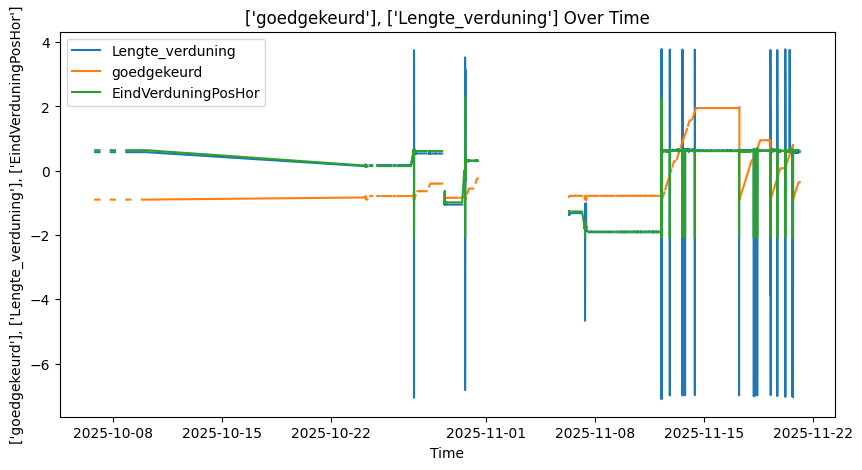

In [55]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

ss = SVRM3_ewon_df_cleaned.copy()
sc = StandardScaler()
ss['goedgekeurd'] = sc.fit_transform(ss[['goedgekeurd']])
ss['Lengte_verduning'] = sc.fit_transform(ss[['Lengte_verduning']])
ss['EindVerduningPosHor'] = sc.fit_transform(ss[['EindVerduningPosHor']])

y_label = ["goedgekeurd"]
y_label_2 = ["Lengte_verduning"]
y_label_3 = ["EindVerduningPosHor"]

plt.figure(figsize=(10, 5))

plt.plot(ss['TimeStr'], ss[y_label_2])
plt.plot(ss['TimeStr'], ss[y_label])
plt.plot(ss['TimeStr'], ss[y_label_3])
plt.xlabel('Time')
plt.ylabel(f"{y_label}, {y_label_2}, {y_label_3}")
plt.title(f'{y_label}, {y_label_2} Over Time')
plt.legend(['Lengte_verduning', 'goedgekeurd', 'EindVerduningPosHor'])
plt.show()

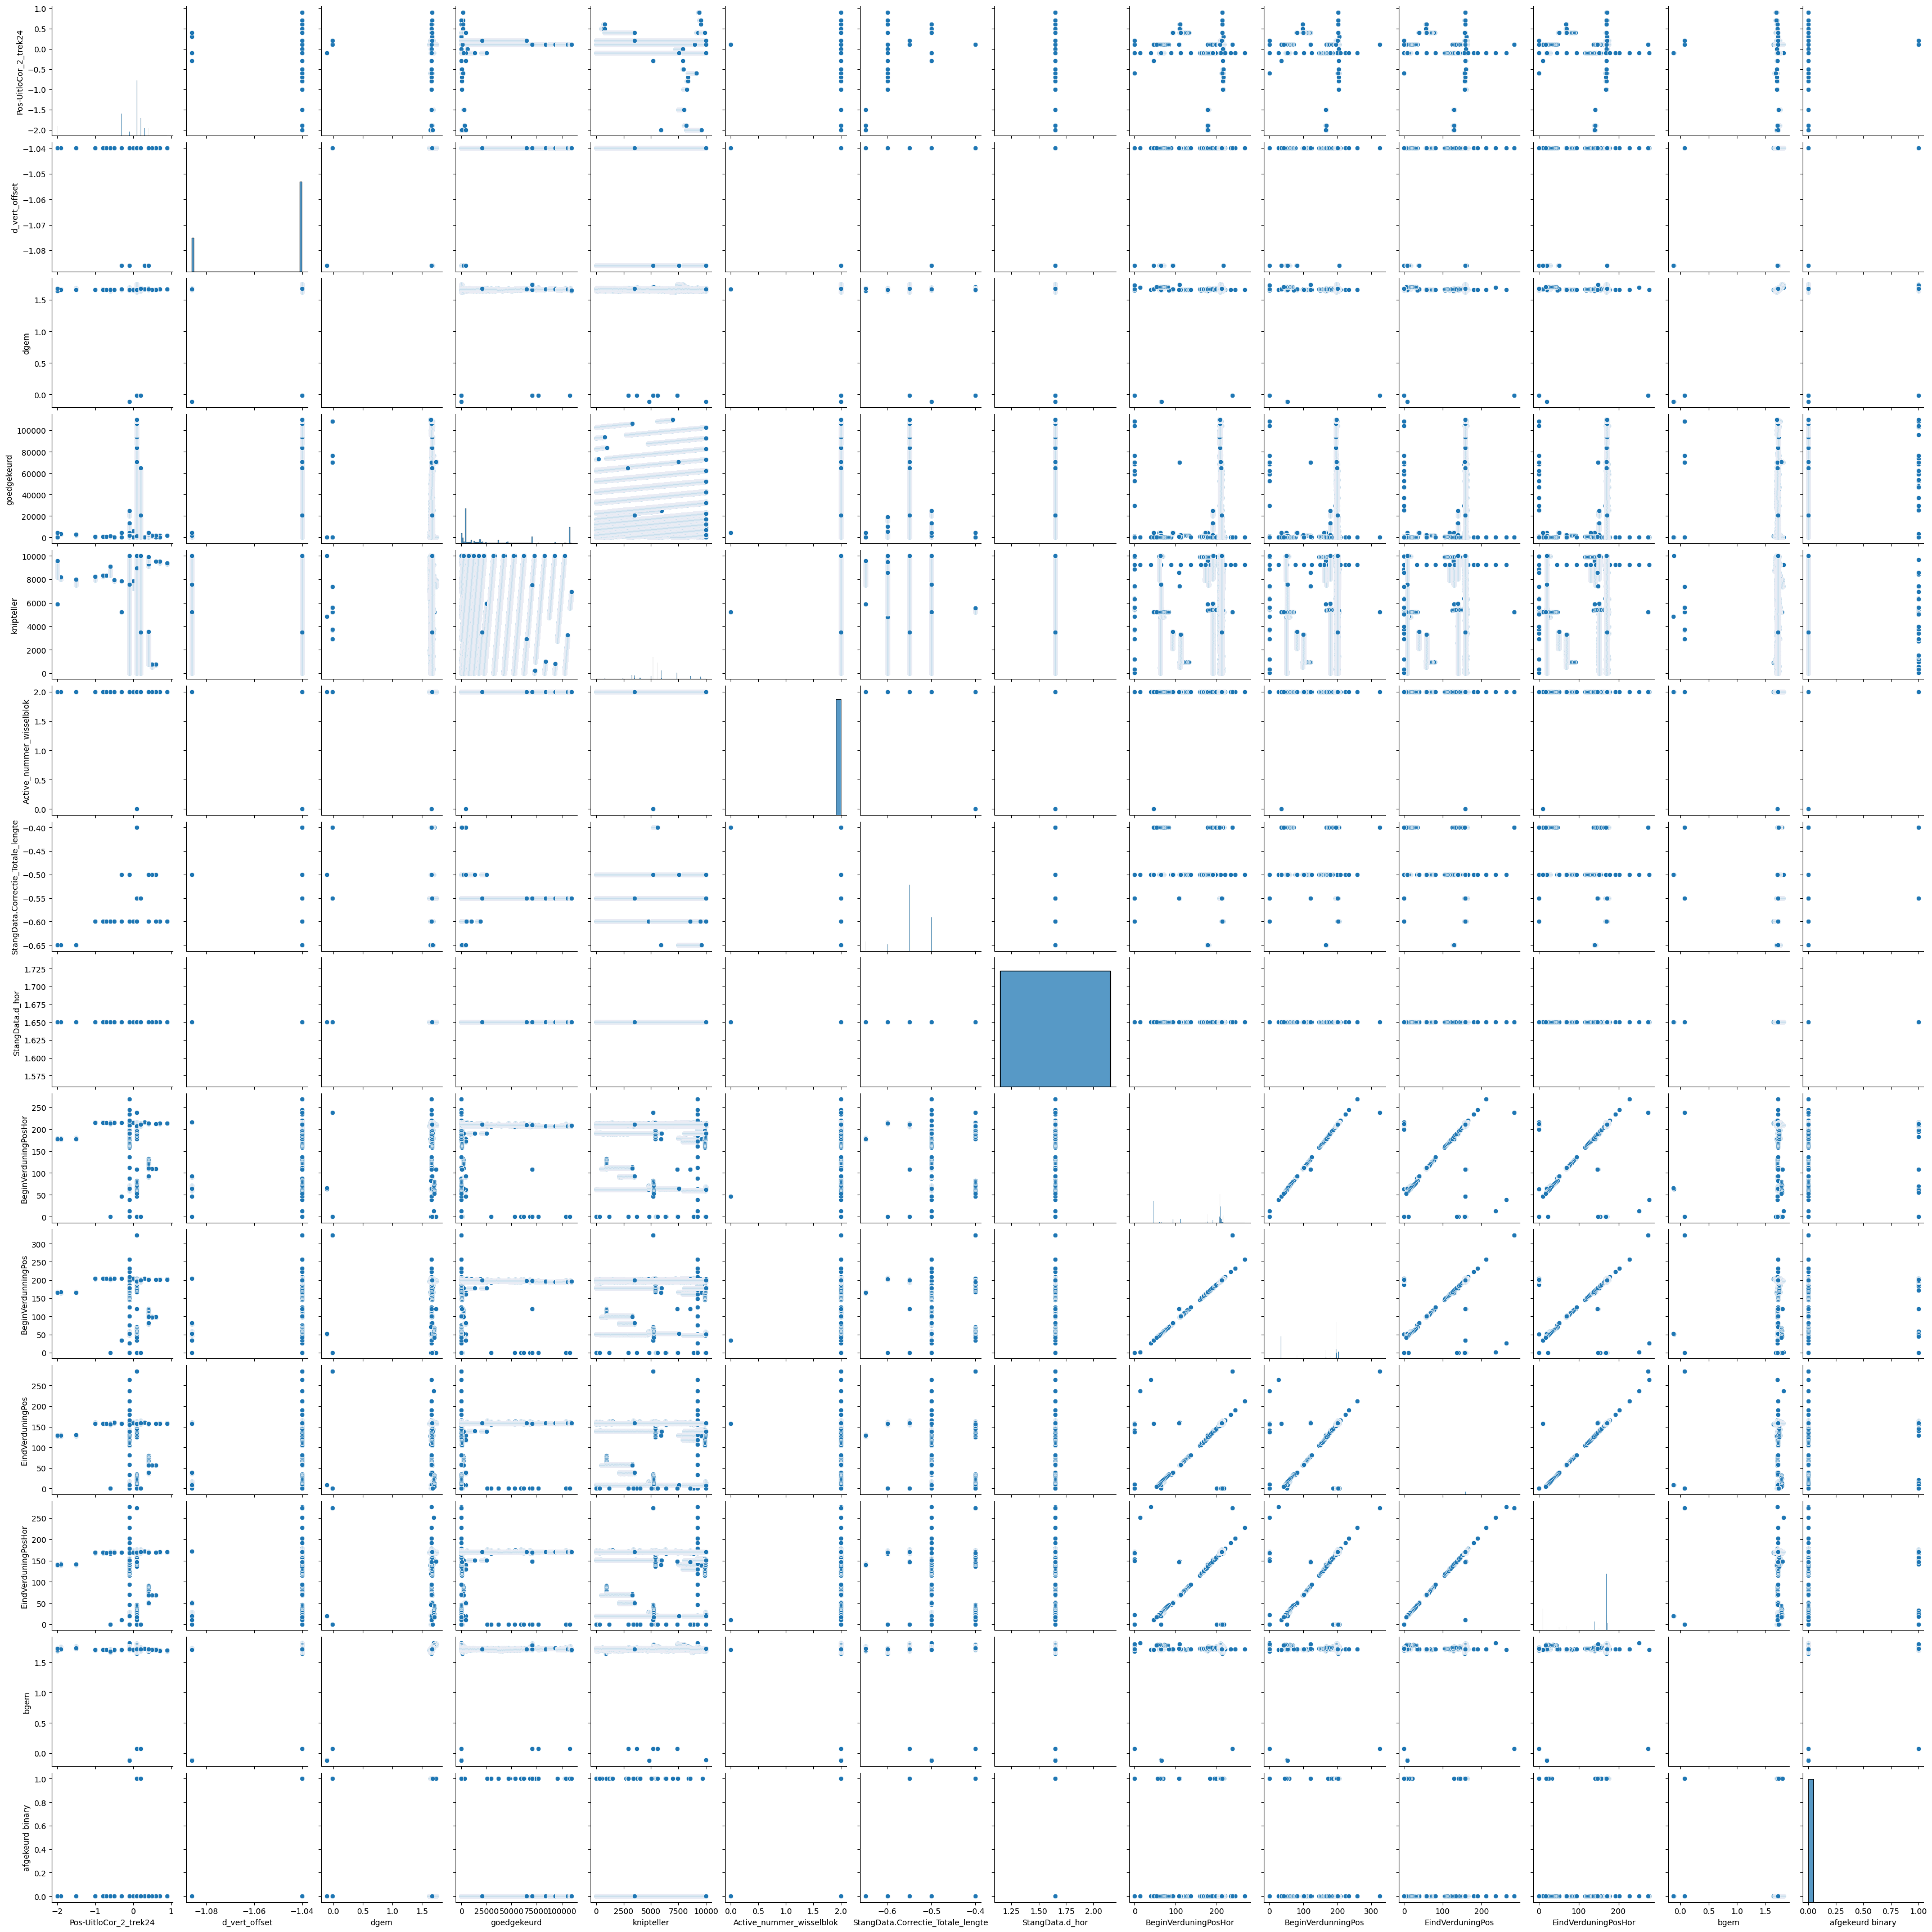

In [51]:
seaborn.pairplot(SVRM3_ewon_df_cleaned[[
"dgem",
"goedgekeurd",
"knipteller",
"Active_nummer_wisselblok",
"StangData.Correctie_Totale_lengte",
"StangData.d_hor",
"BeginVerduningPosHor",
"BeginVerdunningPos",
"EindVerduningPos",
"EindVerduningPosHor",
"bgem",
"afgekeurd binary"]])

plt.show()

<Axes: >

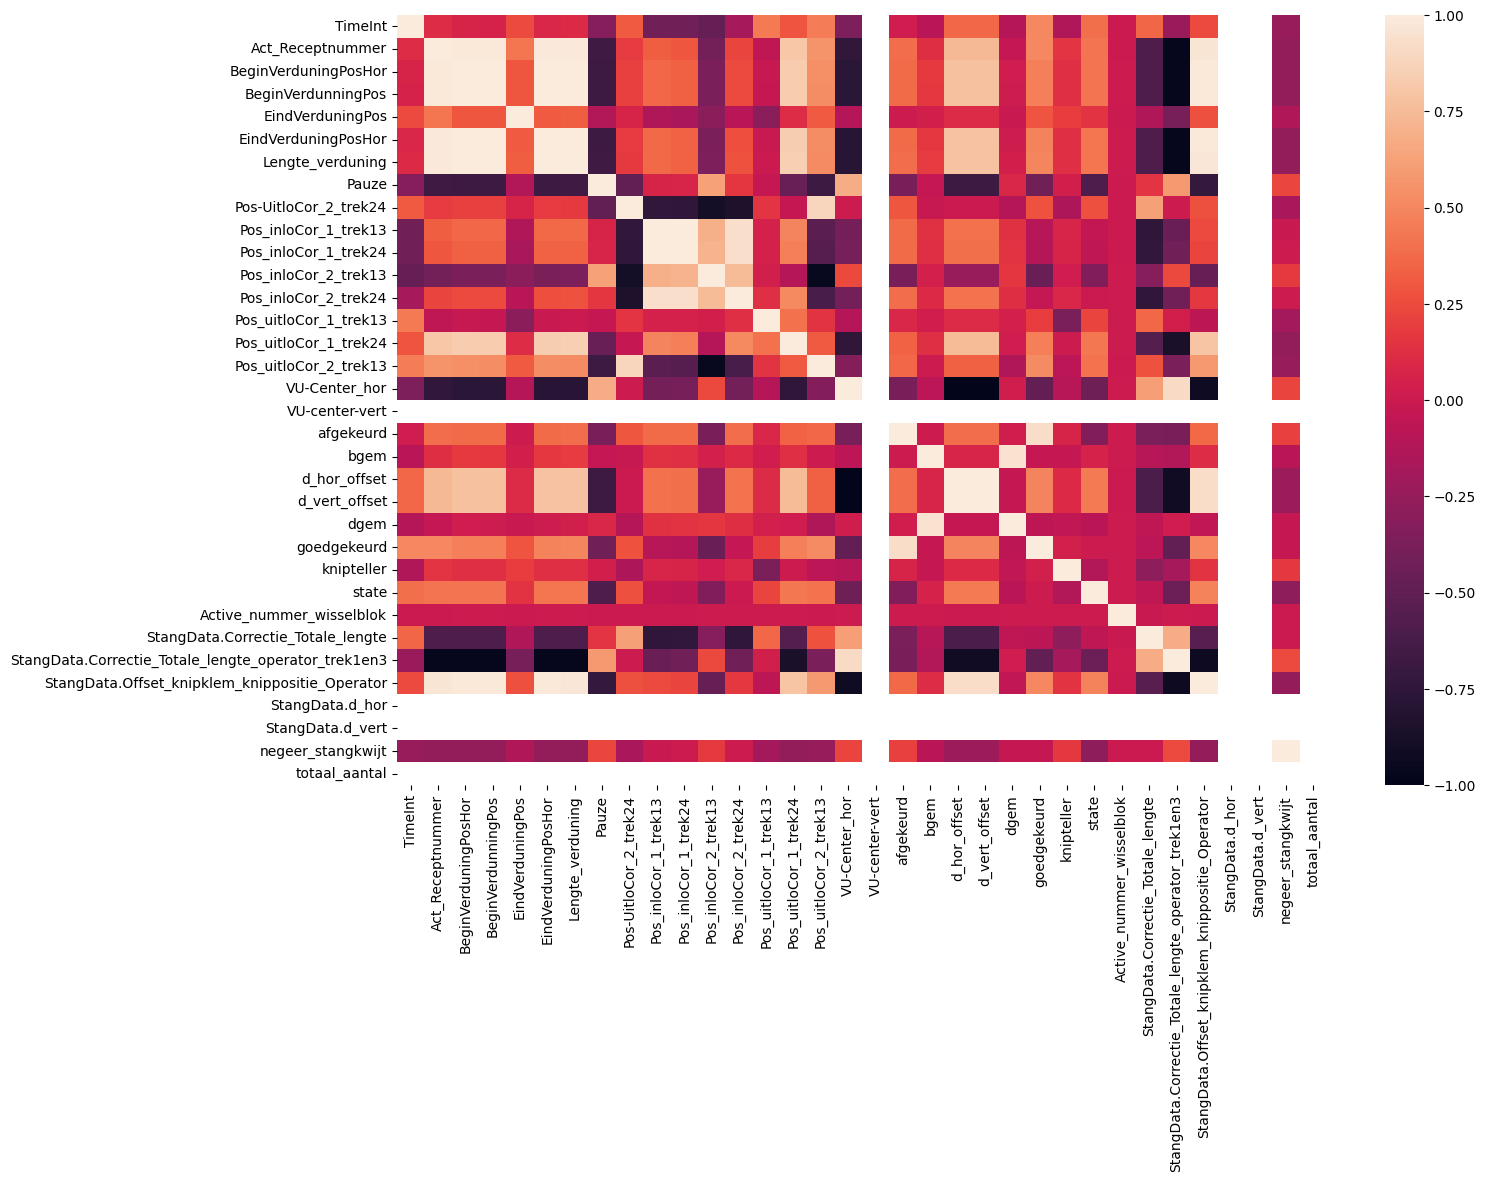

In [65]:
matrix = SVRM3_ewon_df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(15, 10)) 
seaborn.heatmap(matrix)

# FEATURE ENGINEERING

In [11]:
SVRM3_ewon_df_cleaned["goedgekeurd"]

1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
            ...   
1117918    20558.0
1117919    20558.0
1117920    20558.0
1117921    20558.0
1117922    20558.0
Name: goedgekeurd, Length: 820690, dtype: float64

In [6]:
# ensure numeric
SVRM3_ewon_df_cleaned['afgekeurd'] = pd.to_numeric(SVRM3_ewon_df_cleaned['afgekeurd'], errors='coerce')

# forward fill for reference
afgekeurd_ffill = SVRM3_ewon_df_cleaned['afgekeurd'].ffill()

# last valid afgekeurd
last_valid = afgekeurd_ffill.shift(1)

# delta calculation
SVRM3_ewon_df_cleaned['delta'] = SVRM3_ewon_df_cleaned['afgekeurd'] - last_valid

# handle resets
SVRM3_ewon_df_cleaned.loc[SVRM3_ewon_df_cleaned['delta'] < 0, 'delta'] = SVRM3_ewon_df_cleaned['afgekeurd']

SVRM3_ewon_df_cleaned["afgekeurd binary"] = (SVRM3_ewon_df_cleaned["delta"].notna() & SVRM3_ewon_df_cleaned["delta"] != 0).astype(int)
SVRM3_ewon_df_cleaned.drop(columns=['delta'], inplace=True)


In [8]:
len(SVRM3_ewon_df_cleaned[SVRM3_ewon_df_cleaned["afgekeurd binary"] == 0])

820458

In [7]:
X = SVRM3_ewon_df_cleaned.iloc[:, 2:-1]
y = SVRM3_ewon_df_cleaned["afgekeurd binary"]

In [8]:
X.columns

Index(['Act_Receptnummer', 'BeginVerduningPosHor', 'BeginVerdunningPos',
       'EindVerduningPos', 'EindVerduningPosHor', 'Lengte_verduning', 'Pauze',
       'Pos-UitloCor_2_trek24', 'Pos_inloCor_1_trek13', 'Pos_inloCor_1_trek24',
       'Pos_inloCor_2_trek13', 'Pos_inloCor_2_trek24', 'Pos_uitloCor_1_trek13',
       'Pos_uitloCor_1_trek24', 'Pos_uitloCor_2_trek13', 'VU-Center_hor',
       'VU-center-vert', 'afgekeurd', 'bgem', 'd_hor_offset', 'd_vert_offset',
       'dgem', 'goedgekeurd', 'knipteller', 'state',
       'Active_nummer_wisselblok', 'StangData.Correctie_Totale_lengte',
       'StangData.Correctie_Totale_lengte_operator_trek1en3',
       'StangData.Offset_knipklem_knippositie_Operator', 'StangData.d_hor',
       'StangData.d_vert', 'negeer_stangkwijt', 'totaal_aantal'],
      dtype='object')

# CORRELATION

In [ ]:
# SVRM3_ewon_df_cleaned[SVRM3_ewon_df_cleaned["afgekeurd binary"] == 1]

SHAP values computed for XGBoost
Shape of SHAP values: (164138, 33)

XGBoost Feature Importance (SHAP):
                                              feature  mean_abs_shap
17                                          afgekeurd       2.376897
24                                              state       1.642813
4                                 EindVerduningPosHor       0.321526
3                                    EindVerduningPos       0.290042
23                                         knipteller       0.232868
5                                    Lengte_verduning       0.206448
21                                               dgem       0.182386
31                                  negeer_stangkwijt       0.154793
18                                               bgem       0.148372
1                                BeginVerduningPosHor       0.139375
2                                  BeginVerdunningPos       0.119417
22                                        goedgekeurd       0.105160

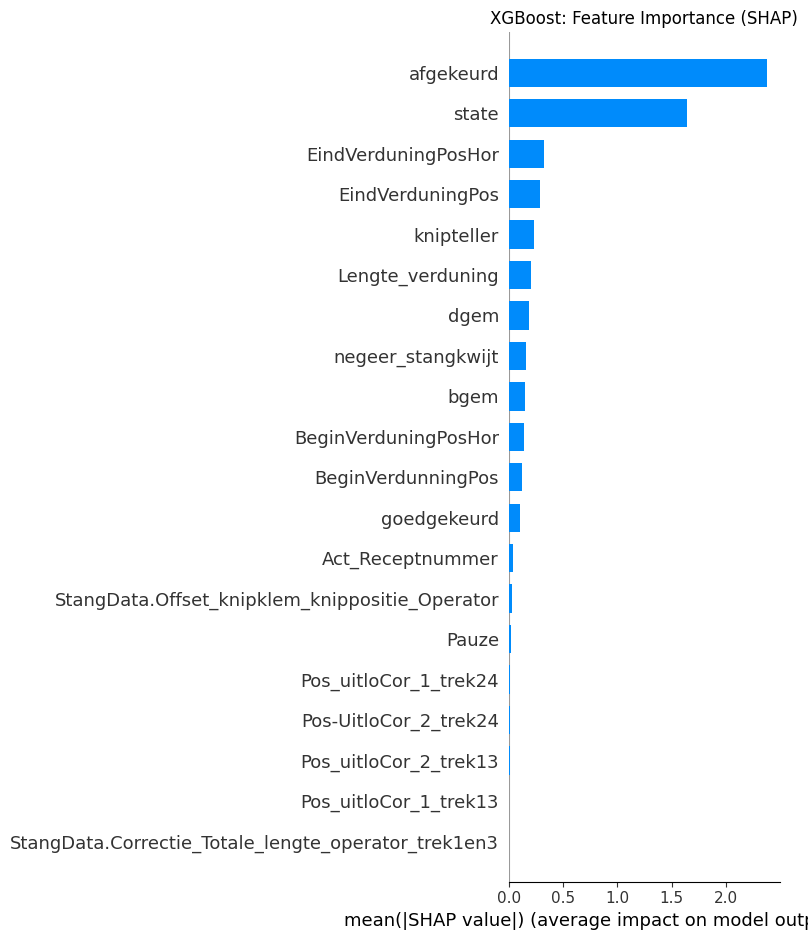

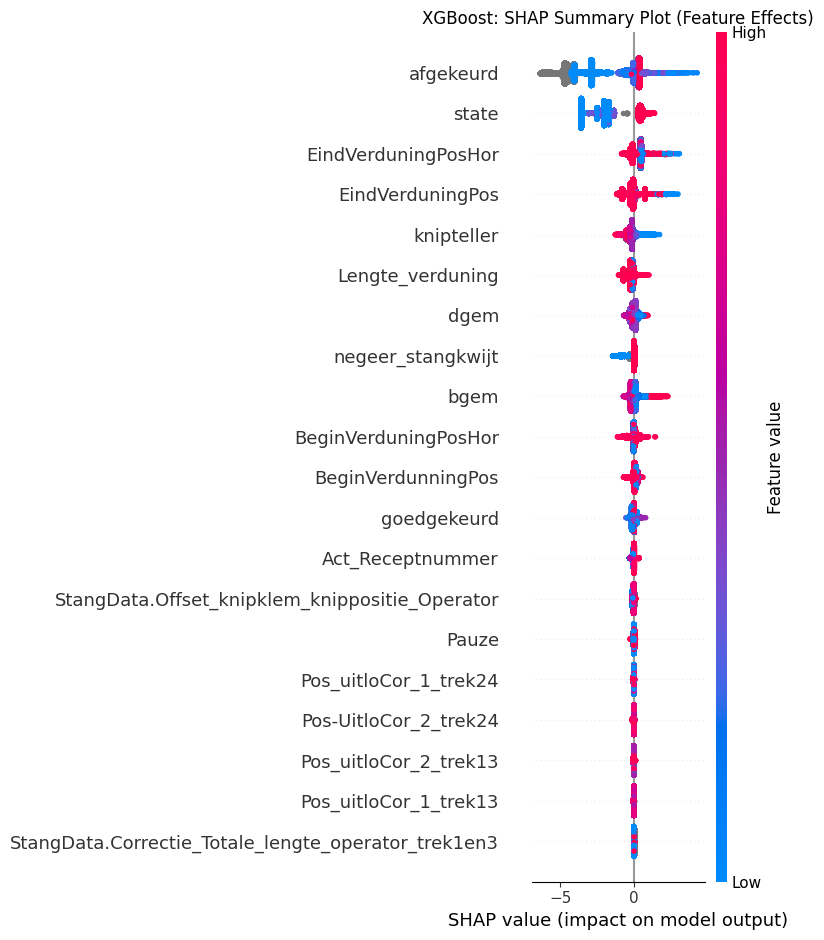

In [14]:


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
import shap

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Create SHAP explainer for XGBoost (TreeExplainer is fast for tree models)
explainer_xgb = shap.TreeExplainer(model)

# Calculate SHAP values for test set
shap_values_xgb = explainer_xgb.shap_values(X_test)

print("SHAP values computed for XGBoost")
print(f"Shape of SHAP values: {shap_values_xgb.shape}")

# Feature importance based on mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values_xgb).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("\nXGBoost Feature Importance (SHAP):")
print(shap_importance)

# Visualizations for XGBoost
print("\nGenerating XGBoost SHAP plots...")

# Summary plot (bar) - feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("XGBoost: Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# Summary plot (beeswarm) - shows feature effects
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title("XGBoost: SHAP Summary Plot (Feature Effects)")
plt.tight_layout()
plt.show()

In [ ]:
SVRM3_ewon_df_cleaned.info()

In [24]:
names = SVRM3_ewon_df_cleaned.columns[2:]
for name, importance in zip(names, importances):
    if importance > 0:
       print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: BeginVerduningPosHor, Importance: 4.12
Feature: Lengte_verduning, Importance: 0.88
Feature: Pos-UitloCor_2_trek24, Importance: 6.54
Feature: Pos_inloCor_1_trek13, Importance: 2.93
Feature: Pos_inloCor_1_trek24, Importance: 0.06
Feature: Pos_inloCor_2_trek13, Importance: 3.85
Feature: Pos_uitloCor_1_trek13, Importance: 9.41
Feature: Pos_uitloCor_1_trek24, Importance: 1.33
Feature: Pos_uitloCor_2_trek13, Importance: 1.25
Feature: bgem, Importance: 4.57
Feature: dgem, Importance: 3.24
Feature: goedgekeurd, Importance: 4.34
Feature: knipteller, Importance: 25.75
Feature: state, Importance: 0.89
Feature: StangData.Correctie_Totale_lengte, Importance: 3.34
Feature: StangData.Correctie_Totale_lengte_operator_trek1en3, Importance: 0.14
Feature: StangData.Offset_knipklem_knippositie_Operator, Importance: 0.55
Feature: Wisselblok_settings[2].Wp1_diameter_offset, Importance: 11.41
Feature: Wisselblok_settings[2].Wp2_diameter_offset, Importance: 7.78
Feature: afgekeurd binary, Importance:

In [ ]:
for lag in range(1, 11):
    SVRM3_ewon_df_cleaned[[f"{col}_lag{lag}" for col in X]] = SVRM3_ewon_df_cleaned[X].shift(lag)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

mi = mutual_info_classif(X_imp, y, random_state=42)

KeyboardInterrupt: 

In [ ]:
SVRM3_ewon_df_cleaned.dtypes[SVRM3_ewon_df_cleaned.dtypes != "float64"]

TimeInt                                                         int64
TimeStr                                                datetime64[ns]
Act_Receptnummer                                               object
BeginVerduningPosHor                                           object
BeginVerdunningPos                                             object
EindVerduningPos                                               object
EindVerduningPosHor                                            object
Lengte_verduning                                               object
Pauze                                                          object
Pos-UitloCor_2_trek24                                          object
Pos_inloCor_1_trek13                                           object
Pos_inloCor_1_trek24                                           object
Pos_inloCor_2_trek13                                           object
Pos_inloCor_2_trek24                                           object
Pos_uitloCor_1_trek1

In [ ]:
SVRM3_ewon_df_cleaned.columns

Index(['TimeInt', 'TimeStr', 'Act_Receptnummer', 'BeginVerduningPosHor',
       'BeginVerdunningPos', 'EindVerduningPos', 'EindVerduningPosHor',
       'Lengte_verduning', 'Pauze', 'Pos-UitloCor_2_trek24',
       'Pos_inloCor_1_trek13', 'Pos_inloCor_1_trek24', 'Pos_inloCor_2_trek13',
       'Pos_inloCor_2_trek24', 'Pos_uitloCor_1_trek13',
       'Pos_uitloCor_1_trek24', 'Pos_uitloCor_2_trek13', 'VU-Center_hor',
       'VU-center-vert', 'afgekeurd', 'bgem', 'd_hor_offset', 'd_vert_offset',
       'dgem', 'goedgekeurd', 'knipteller', 'state',
       'Active_nummer_wisselblok', 'StangData.Correctie_Totale_lengte',
       'StangData.Correctie_Totale_lengte_operator_trek1en3',
       'StangData.Offset_knipklem_knippositie_Operator', 'StangData.d_hor',
       'StangData.d_vert', 'Wisselblok_settings[2].Wp1_diameter_offset',
       'Wisselblok_settings[2].Wp1_hartlijn_offset',
       'Wisselblok_settings[2].Wp2_diameter_offset',
       'Wisselblok_settings[2].Wp2_hartlijn_offset',
       'Wis